# Section 2: TensorBoard
Included in the TensorFlow installation is a tool called TensorBoard. With this tool you can visualise everything coming into your neural network and leaving your neural network. In this section I will demonstrate how you can use it. In later sections we will continue to use it to monitor our neural network (training) using TensorBoard. 

## Video 1: starting TensorBoard and visualising a graph
Let's say you are developing a deep neural network that can recognize characters. We take the classic MNIST dataset and quickly build a neural network using `tf.layers`. 

In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt 
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('datasets/MNIST_data', one_hot=True)
input_dim = mnist.train.images[0].shape[0]
output_dim = 10
h_image=28
w_image=28

Extracting datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
tf.reset_default_graph()

## INPUT AND OUTPUT PLACEHOLDER
input_placeholder = tf.placeholder(dtype=tf.float32, shape=[None, input_dim], name='inputplaceholder')
output_placeholder = tf.placeholder(dtype=tf.float32, shape=[None, output_dim], name='outputplaceholder')

reshaped_input = tf.reshape(input_placeholder, [-1, h_image, w_image, 1])
conv1 = tf.layers.conv2d(reshaped_input, 32, [3,3], activation=tf.nn.relu, name="conv1")
conv1_mp = tf.layers.max_pooling2d(conv1, [2,2], [2,2])
conv2 = tf.layers.conv2d(conv1_mp, 32, [3,3], activation=tf.nn.relu, name="conv2")
conv2_mp = tf.layers.max_pooling2d(conv2, [2,2], [2,2])
conv3 = tf.layers.conv2d(conv2_mp, 32, [3,3], activation=tf.nn.relu, name="conv3")
flattened = tf.contrib.layers.flatten(conv3)

print(flattened)
output = tf.layers.dense(flattened, output_dim, activation=None)
loss = tf.losses.sigmoid_cross_entropy(output_placeholder, output)
optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

Tensor("Flatten/Reshape:0", shape=(?, 288), dtype=float32)
INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.


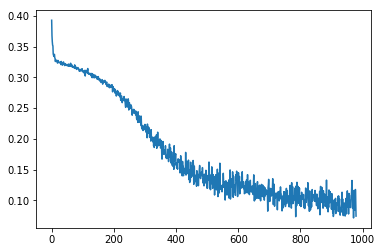

In [3]:

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

iterations = 1000
batch_size = 128
loss_history = list()
for iteration in range(iterations):
    batch = mnist.train.next_batch(batch_size)
    _, l = sess.run([optimizer, loss],
                                feed_dict={input_placeholder: batch[0], output_placeholder: batch[1]})
    loss_history.append(l)

plt.plot(loss_history[20:])
plt.show()


### What is Tensorboard?
By now you probably noticed that building a model and training a neural network can be a lot of fidgeting with hyper parameters and layers. Sometimes it can be difficult to see the performance between two models, and debugging models is often difficult. A tool that really helps you with this is Tensorboard: a web application that reads event files you can write away with TensorFlow. 


### Starting Tensorboard
When you ran `docker-compose up` you not only started a virtual operating system with Tensorflow and Jupyter notebook, but also started a server that runs Tensorboard. Tensorboard is now accessible by navigating to `localhost:6006`. As we did not use it yet, you will probably see the following screen: 

![tensorempty](illustrations/section2/tensorboardempty.png)

This is because we did not write anything yet. 

### Writing your graph

To write your graph (and any other data) you have to initialize a Filewrite object. The constructor requires you to give the name of the directory you want to log in, and the graph you want to use for this writer. 

During this course we write everything to the graphs directory (as Tensorboard looks in this directory). Apart from the we make a directory per section during this course. After you did this there is one more thing remaining: it is good practice to put each model you make (every time you change something you have a new model) in a separate folder. You will see later why this is useful. Now let's start by starting a FileWriter:

In [4]:
writer = tf.summary.FileWriter(logdir='graphs/tensorboardexplanation/firstwriter' , graph=tf.get_default_graph())

If you wait a while, or refresh the Tensorboard page, you should be able to navigate to the Graphs tab, and visualise your graph:
![tensorempty](illustrations/section2/foundrun.png)

Note: sometimes you have to refresh Tensorboard before he finds your graph definition... 

![tensorempty](illustrations/section2/firstgraphvis.png)

The gradients block makes everything a bit difficult to inspect, so you can remove this by clicking on the gradients with your right mouse button. 

![tensorempty](illustrations/section2/removefromgraph.png)

This should give your the following graph: 

![tensorempty](illustrations/section2/nicegraph.png)


## Video 2: Adding summaries

Now that we are able to get our graph in Tensorboard it's time to add something more interesting: the loss. Right now we are working with Matplotlib, and either have to store the losses somewhere, or have to figure out what model works better...

With Tensorboard we can simply improve on this by using multiple logging directories. Especially with a Jupyter Notebook doing this is easy. Here is my normal working routing when trying to build a good neural network: 
- Determine in what directory I will log, set a variable to zero
- Build a (simple) initial graph
- Write things to a directory (and increment variable by one for next time)
- Adjust network!

Let's start with the first step, and set a variable to zero and make a directory: 

In [5]:
logging_dir_n = 0 

### Actually logging something
So far we did not log anything, we can do so by adding a scalar summary of the loss value. Note that instead of the next block I do this in the block after that: 

In [6]:
tf.reset_default_graph()

input_placeholder = tf.placeholder(dtype=tf.float32, shape=[None, input_dim], name='inputplaceholder')
output_placeholder = tf.placeholder(dtype=tf.float32, shape=[None, output_dim], name='outputplaceholder')

reshaped_input = tf.reshape(input_placeholder, [-1, h_image, w_image, 1])
conv1 = tf.layers.conv2d(reshaped_input, 32, [3,3], activation=tf.nn.relu, name="conv1")
conv1_mp = tf.layers.max_pooling2d(conv1, [2,2], [2,2])
conv2 = tf.layers.conv2d(conv1_mp, 32, [3,3], activation=tf.nn.relu, name="conv2")
conv2_mp = tf.layers.max_pooling2d(conv2, [2,2], [2,2])
conv3 = tf.layers.conv2d(conv2_mp, 32, [3,3], activation=tf.nn.relu, name="conv3")

flattened = tf.contrib.layers.flatten(conv3)
output = tf.layers.dense(flattened, output_dim, activation=None)

loss = tf.losses.sigmoid_cross_entropy(output_placeholder, output)
optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.


In [7]:
loss_summary = tf.summary.scalar('loss', loss)

In [8]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter(logdir='graphs/tensorboardexplanation/tutorial/'+str(logging_dir_n) , graph=tf.get_default_graph())
logging_dir_n += 1


### Writing to the summary
Instead of asking the graph to give me the loss each iteration I now ask the graph to give me the summary of the loss. I collect all summaries and add them to my writer...

In [9]:
for iteration in range(iterations):
    batch = mnist.train.next_batch(batch_size)
    _, summary = sess.run([optimizer, loss_summary],
                                feed_dict={input_placeholder: batch[0], output_placeholder: batch[1]})
    writer.add_summary(summary, iteration)

### Adjusting your graph
Now that we have a first loss we can adjust our graph, and see if the loss improves (or becomes worse...). 

In [10]:
optimizer = tf.train.AdamOptimizer().minimize(loss)

In [11]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter(logdir='graphs/tensorboardexplanation/tutorial/'+str(logging_dir_n) , graph=tf.get_default_graph())
logging_dir_n += 1


In [12]:
for iteration in range(iterations):
    batch = mnist.train.next_batch(batch_size)
    _, summary = sess.run([optimizer, loss_summary],
                                feed_dict={input_placeholder: batch[0], output_placeholder: batch[1]})
    writer.add_summary(summary, iteration)

### Conclusion
You can now see the difference between two optimizers, all in one graph! Although you can easily see the difference in quality between two layouts, you can now easily change part of the graph, train, and see the difference with your previous results. 

## Video 3: inspecting weights

Let's say that you totally misinterpreted the learning rate: 

In [37]:
loss = tf.losses.mean_squared_error(output_placeholder, output)
optimizer = tf.train.GradientDescentOptimizer(4.5).minimize(loss)
iterations = 50

In [38]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter(logdir='graphs/tensorboardexplanation/tutorial/'+str(logging_dir_n) , graph=tf.get_default_graph())
logging_dir_n += 1

for iteration in range(iterations):
    batch = mnist.train.next_batch(batch_size)
    _, l, summary = sess.run([optimizer, loss, loss_summary],
                                feed_dict={input_placeholder: batch[0], output_placeholder: batch[1]})
    print(l)
    writer.add_summary(summary, iteration)

0.124975
0.391151
0.410753
32.1005
24.8317
5.39569
11.9054
0.465106
0.0937922
0.0897405
0.0914311
0.0904819
0.0908581
0.0903916
0.0902783
0.0908097
0.0897422
0.0903243
0.0912863
0.0902907
0.0906799
0.0910673
0.090572
0.0913428
0.0910211
0.0902002
0.0897306
0.0906953
0.0900082
0.0899592
0.0918764
0.090437
0.0901751
0.0902231
0.0901788
0.0911987
0.0901641
0.089908
0.0914725
0.0906947
0.0915322
0.0902214
0.0913384
0.0919104
0.0902416
0.0902843
0.0910322
0.0907589
0.0913022
0.0912314



Looking at Tensorboard you now see the loss go up, but you have no idea why. The graph looks really good (no wrong passes...), but you clearly see your loss going up. 

Now is a good time to either inspect your gradients, inspect activations, or inspect your weights. Let's take weights for example: 


In [39]:
## Print variable names; 
for v in tf.global_variables():
    print(v.name)

conv1/kernel:0
conv1/bias:0
conv2/kernel:0
conv2/bias:0
conv3/kernel:0
conv3/bias:0
dense/kernel:0
dense/bias:0
beta1_power:0
beta2_power:0
conv1/kernel/Adam:0
conv1/kernel/Adam_1:0
conv1/bias/Adam:0
conv1/bias/Adam_1:0
conv2/kernel/Adam:0
conv2/kernel/Adam_1:0
conv2/bias/Adam:0
conv2/bias/Adam_1:0
conv3/kernel/Adam:0
conv3/kernel/Adam_1:0
conv3/bias/Adam:0
conv3/bias/Adam_1:0
dense/kernel/Adam:0
dense/kernel/Adam_1:0
dense/bias/Adam:0
dense/bias/Adam_1:0


You can visualise a histogram with the `tf.summary.histogram` function. We do this for each kernel in our graph by adding a histogram for each variable with the name "kernel". 

In [40]:
histograms = []
for v in tf.global_variables():
    if "kernel" in v.name:
        toadd = tf.summary.histogram(v.name[:-2], v)
        histograms.append(toadd)

Now you can log these in our summary!

In [41]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter(logdir='graphs/tensorboardexplanation/tutorial/'+str(logging_dir_n) , graph=tf.get_default_graph())
logging_dir_n += 1

In [42]:
for iteration in range(iterations):
    batch = mnist.train.next_batch(batch_size)
    _, summary = sess.run([optimizer, loss_summary],
                                feed_dict={input_placeholder: batch[0], output_placeholder: batch[1]})
    writer.add_summary(summary, iteration)
    
    ## Log the histograms of weights and add them as a summary
    weights_in_graph = sess.run(histograms)
    for logged_weight in weights_in_graph: 
        writer.add_summary(logged_weight, iteration)

### Comparing it to a "normal" situation
Now let's compare this to a "normal" situation, where we hopefully don't see all weights explode:

In [43]:
loss = tf.losses.mean_squared_error(output_placeholder, output)
optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter(logdir='graphs/tensorboardexplanation/tutorial/'+str(logging_dir_n) , graph=tf.get_default_graph())
logging_dir_n += 1

In [44]:
for iteration in range(iterations):
    batch = mnist.train.next_batch(batch_size)
    _, summary = sess.run([optimizer, loss_summary],
                                feed_dict={input_placeholder: batch[0], output_placeholder: batch[1]})
    writer.add_summary(summary, iteration)
    weights_in_graph = sess.run(histograms)
    for logged_weight in weights_in_graph: 
        writer.add_summary(logged_weight, iteration)

## Video 4: inspecting input/output
You can even use TensorBoard to show your input and outputs. Use the image summary to add an image to Tensorboard. This can help you when your network is not learning anything: it might just be possible that your network is not receiving any sensible input at all!

In [ ]:
image_summary = tf.summary.image('inputimage', reshaped_input)

In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter(logdir='graphs/tensorboardexplanation/tutorial/'+str(logging_dir_n) , graph=tf.get_default_graph())
logging_dir_n += 1

In [ ]:
for iteration in range(10):
    batch = mnist.train.next_batch(batch_size)
    _, summary, im_sum = sess.run([optimizer, loss_summary, image_summary],
                                feed_dict={input_placeholder: batch[0], output_placeholder: batch[1]})
    writer.add_summary(summary, iteration)
    writer.add_summary(im_sum, iteration)

### Merging summaries
Right now we ask for each summary separately in our session. Luckily Tensorboard can improve on this by using the following function: 

In [ ]:
merged = tf.summary.merge_all()

In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter(logdir='graphs/tensorboardexplanation/tutorial/'+str(logging_dir_n) , graph=tf.get_default_graph())
logging_dir_n += 1

In [ ]:
for iteration in range(iterations):
    batch = mnist.train.next_batch(batch_size)
    _, summary = sess.run([optimizer, merged],
                                feed_dict={input_placeholder: batch[0], output_placeholder: batch[1]})
    writer.add_summary(summary, iteration)
    

### Conclusion
We are now logging all summaries we defined to Tensorboard! You can define way more things you want to log, like the accuracy of your network, other loss functions, activations in different layers, whatever you want! We will use Tensorboard in the next section, so you can easily tinker with your graph and see how well it improves the performance. 